### Fazer a análise exploratória, buscando identificar quais variáveis numéricas melhor separam as classes
### Criar boxplots com os resultados da validação cruzada de vários algoritmos
### Fazer feature selection
### Verificar o balanceamento
### Codificar variáveis categóricas
### Rodar um GridSearch para otimizar os hiperparâmetros

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif, chi2, f_classif

In [3]:
#!pip install --user imblearn

In [ ]:
df = pd.read_csv('projeto4_telecom_treino.csv')

In [6]:
df.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [7]:
df.shape

(3333, 21)

## A primeira coluna é uma contagem e não tem utilidade

In [8]:
df = df.iloc[:,1:]

In [9]:
df.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [10]:
c=0
obj=[]
for x in df.dtypes:
    if x=='object':
        obj.append(c)
    c+=1

In [11]:
df.iloc[:,obj].nunique()

state                 51
area_code              3
international_plan     2
voice_mail_plan        2
churn                  2
dtype: int64

In [12]:
df.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
numericas = []
for x in df.columns:
    if df[x].dtype=='int64' or df[x].dtype=='float64':
        numericas.append(x)

In [15]:
len(numericas)

15

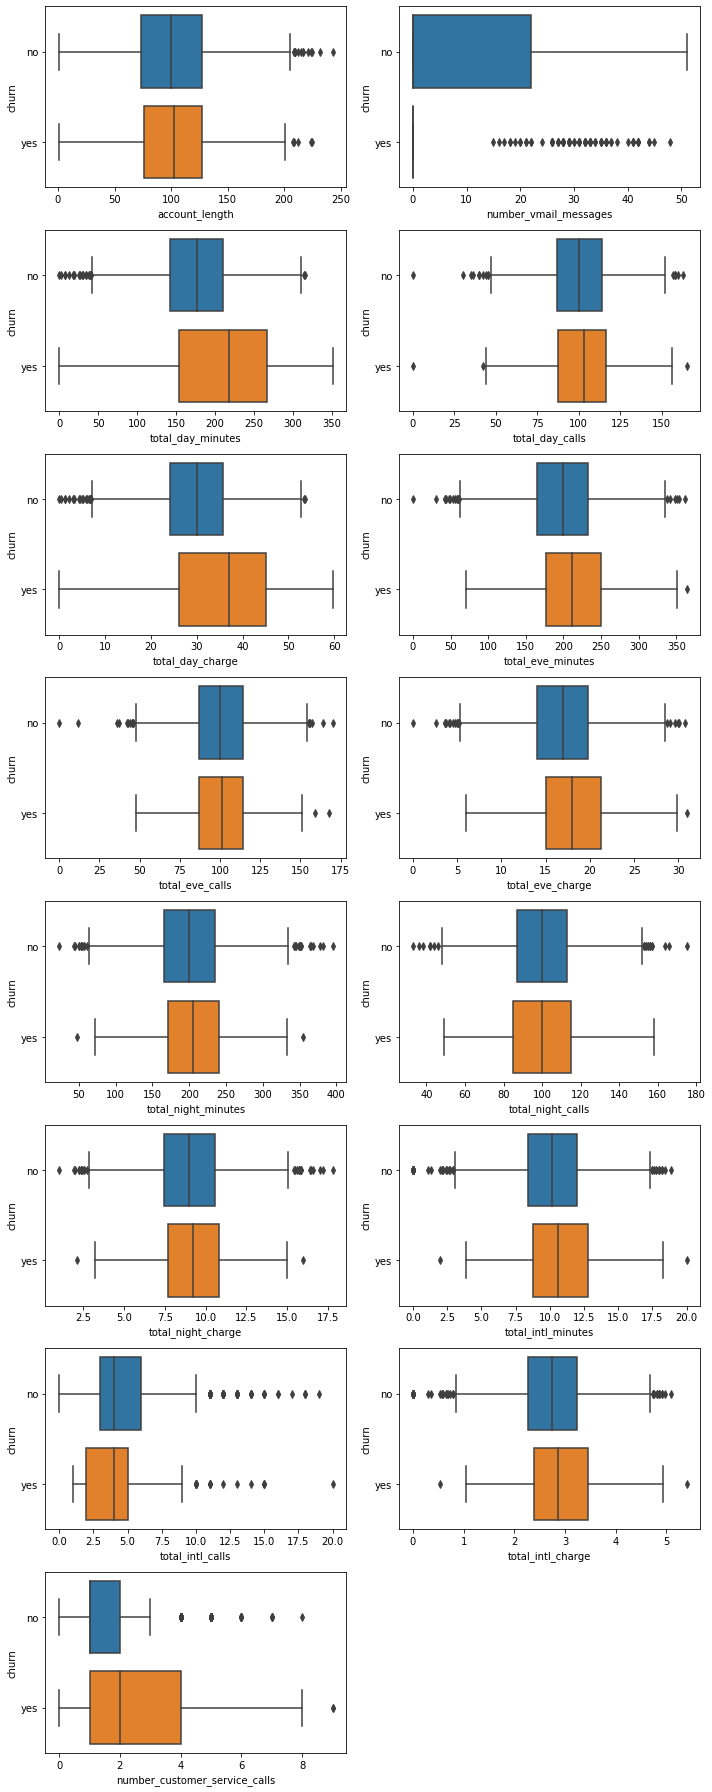

In [16]:
i=0
plt.figure(figsize=(10,25))
for col in numericas:
    i+=1
    plt.subplot(8,2,i)
    sns.boxplot(data=df,x=col,y='churn')
    plt.tight_layout()

## Os clientes que tem mais tempo de chamada durante o dia (mas não necessariamente fazem mais ligações) e que mais pagam (por esse serviço) são os que mais cancelam a linha

## Clientes que cancelam a linha ligam mais para o atendimento ao cliente

In [17]:
df[['total_day_calls','total_day_minutes']].corr()

,total_day_calls,total_day_minutes
total_day_calls,1.00000,0.00675
total_day_minutes,0.00675,1.00000


## Dentre as variáveis numéricas, as que não separam bem as classes são: account_length, total_night_charge, total_night_minutes, total_day_calls, total_eve_calls, total_night_calls

In [18]:
categoricas = [x for x in df.columns if x not in numericas and x!='churn']

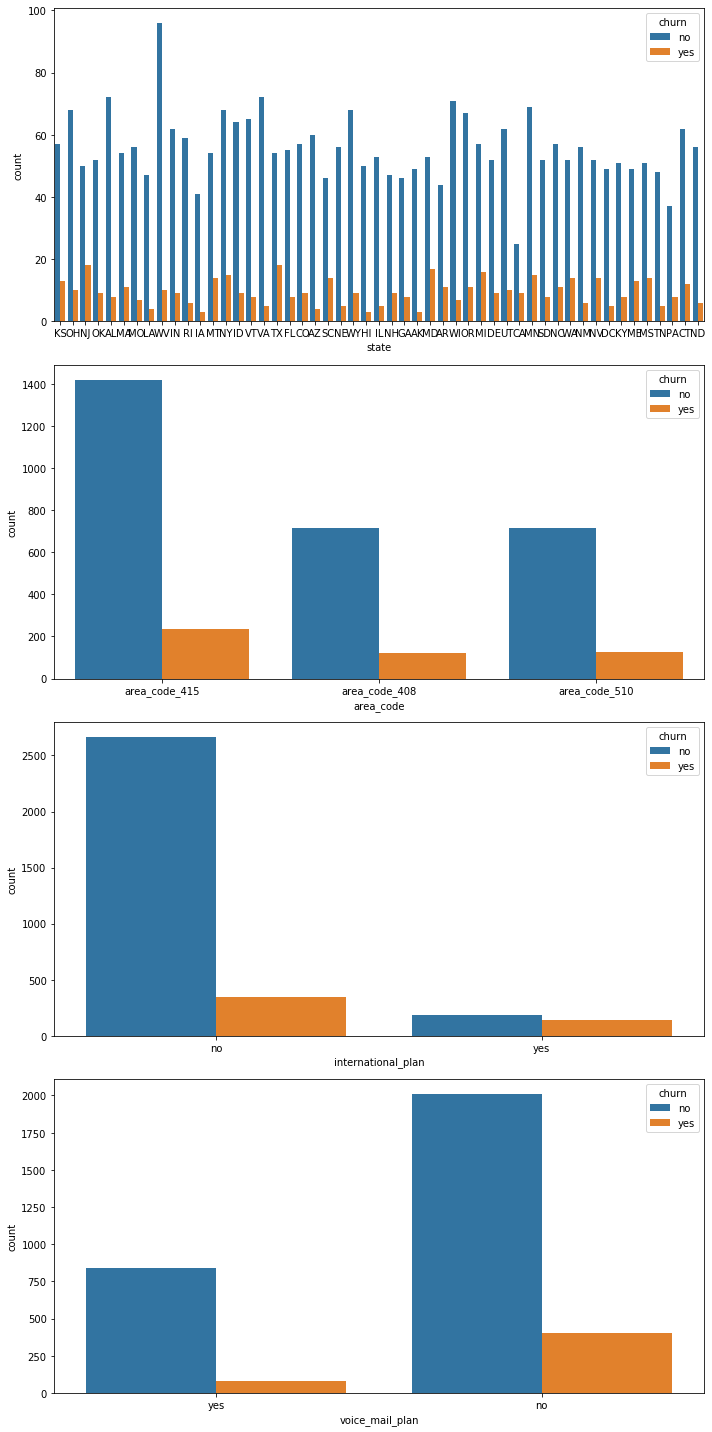

In [19]:
i=0
plt.figure(figsize=(10,20))
for col in categoricas:
    i+=1
    plt.subplot(len(categoricas),1,i)
    sns.countplot(data=df,x=col,hue='churn')
    plt.tight_layout()

## Quase todos os clientes com um plano internacional cancelam a linha

## Testando a associação entre as variáveis categóricas e a classe
## H0: Não existe associação entre as variáveis

In [20]:
for x in categoricas:
    contingencia = pd.crosstab(index=df['churn'],columns=df[x])
    print(f'A probabilidade de erro ao rejeitar H0 entre churn e {x} é: {chi2_contingency(contingencia)[1]*100:.2f}%\n')

A probabilidade de erro ao rejeitar H0 entre churn e state é: 0.23%

A probabilidade de erro ao rejeitar H0 entre churn e area_code é: 91.51%

A probabilidade de erro ao rejeitar H0 entre churn e international_plan é: 0.00%

A probabilidade de erro ao rejeitar H0 entre churn e voice_mail_plan é: 0.00%



## Conclui-se que todas as variáveis categóricas tem associação com a saída, exceto area_code

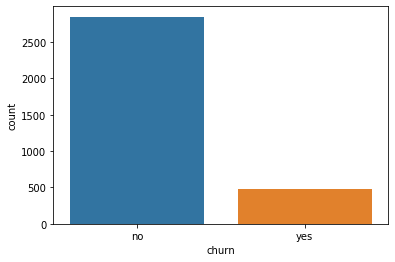

In [21]:
sns.countplot(data=df,x='churn');

In [22]:
df['churn'].value_counts()

no     2850
yes     483
Name: churn, dtype: int64

## Os dados estão bem desbalanceados, espera-se que a acurácia do modelo seja melhor para a classe "no". Se for o caso, usar técnicas de rebalanceamento

## Codificando variáveis categóricas

In [23]:
onehot = OneHotEncoder(sparse=False)

In [24]:
categoricas_cod = onehot.fit_transform(df[categoricas])

In [25]:
numericas = df[numericas].values

In [26]:
minmax = MinMaxScaler()
numericas_s = minmax.fit_transform(numericas)

In [27]:
todas_var = np.concatenate([numericas_s,categoricas_cod],axis=1)

In [28]:
y = df['churn'].values

## Testando validação cruzada sem feature selection e rebalanceamento

In [29]:
y_encod = []
for x in y:
    if x=='yes':
        y_encod.append(1)
    else:
        y_encod.append(0)

In [30]:
kf = KFold(n_splits=10)
modelos = [('RandomForest',RandomForestClassifier()),('KNN',KNeighborsClassifier()),('Reg. L.',LogisticRegression()),\
          ('SVM',SVC()),('NB',GaussianNB()),('LDA',LinearDiscriminantAnalysis()),('XGBoost',XGBClassifier(use_label_encoder=False))]

In [31]:
resultados=[]
for _,modelo in modelos:
    resultados.append(cross_val_score(modelo,todas_var,y_encod,cv=kf,scoring='balanced_accuracy',n_jobs=-1))

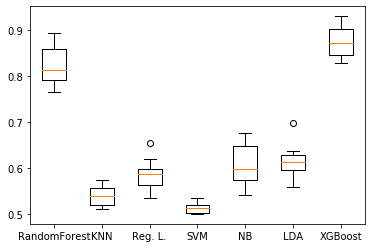

In [32]:
nomes = [x[0] for x in modelos]
plt.boxplot(resultados,labels=nomes);

## XGBoost é o que teve o melhor desempenho

## Esse algoritmo pede que as classes sejam números inteiros

## 1: Yes , 0: No

In [33]:
x_treino, x_teste, y_treino, y_teste = train_test_split(todas_var,y_encod,test_size=0.3,random_state=1)

In [34]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_treino,y_treino)

[18:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [35]:
prev_xgb = xgb.predict(x_teste)

In [36]:
print(classification_report(prev_xgb,y_teste))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       872
           1       0.75      0.85      0.80       128

    accuracy                           0.94      1000
   macro avg       0.86      0.91      0.88      1000
weighted avg       0.95      0.94      0.95      1000



In [37]:
confusao = confusion_matrix(y_teste,prev_xgb,labels=[0,1])
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 0: 97.7778%
Acurácia classe 1: 75.1724%


## A classe 1 tem uma acurácia de 75%, vou tentar melhorar ela com rebalanceamento

In [38]:
y_treino.count(0)/np.array(y_treino).shape[0]

0.8551221603086155

## Antes a classe 0 era 85% dos dados

In [39]:
smote = SMOTE(sampling_strategy='minority',random_state=1,k_neighbors=9)

In [40]:
x_treino_over, y_treino_over = smote.fit_resample(x_treino,y_treino)

In [41]:
y_treino_over.count(0)/np.array(y_treino_over).shape[0]

0.5

## Depois passou a ser 50%

In [42]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_treino_over,y_treino_over)

[18:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [43]:
prev_xgb_over = xgb.predict(x_teste)

In [44]:
print(classification_report(prev_xgb_over,y_teste))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       866
           1       0.76      0.82      0.79       134

    accuracy                           0.94      1000
   macro avg       0.87      0.89      0.88      1000
weighted avg       0.94      0.94      0.94      1000



In [45]:
confusao = confusion_matrix(y_teste,prev_xgb_over,labels=[0,1])
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 0: 97.1930%
Acurácia classe 1: 75.8621%


## Não houve melhora significativa

## Testando se a feature selection melhora o modelo:
### 1) ExtraTreesClassifier, 2) RFE e 3) SelectKBest

## 1) ExtraTreesClassifier

## Preciso criar um dataframe sem variáveis dummy para que eu possa saber qual variável é qual na hora de obter o score de cada variável. Uma vez que usei o OneHotEncoder, não posso usar o todas_var para treinar o modelo

In [46]:
num = []
for x in df.columns:
    if df[x].dtype=='int64' or df[x].dtype=='float64':
        num.append(x)

In [47]:
lab_enc = LabelEncoder()

In [48]:
df_extra = pd.DataFrame()

In [49]:
for x in categoricas:
    lab_enc.fit(df[x].values)
    df_extra[x] = lab_enc.transform(df[x].values)

In [50]:
for x in num:
    df_extra[x] = df[x]

In [51]:
extra = ExtraTreesClassifier()

In [52]:
extra.fit(df_extra.values,y)

ExtraTreesClassifier()

In [53]:
extra.feature_importances_

array([0.03403826, 0.02278342, 0.07303202, 0.01924763, 0.03509282,
       0.01909644, 0.11515358, 0.0351788 , 0.12567103, 0.05706469,
       0.03293801, 0.05677784, 0.03953478, 0.03443151, 0.03706726,
       0.04544579, 0.05215422, 0.04620206, 0.11908984])

## Recuperando a ordem das colunas que foram usadas para treinar o modelo

In [54]:
c=0
dic={}
for x in df_extra.columns:
    dic[x]=extra.feature_importances_[c]
    c+=1

In [55]:
dic

{'state': 0.03403826287938487,
 'area_code': 0.022783421847849712,
 'international_plan': 0.07303202122735597,
 'voice_mail_plan': 0.01924762576392672,
 'account_length': 0.03509282025410605,
 'number_vmail_messages': 0.019096438135300674,
 'total_day_minutes': 0.11515357877196239,
 'total_day_calls': 0.03517880483448032,
 'total_day_charge': 0.12567102623509915,
 'total_eve_minutes': 0.05706468809609924,
 'total_eve_calls': 0.03293801285131599,
 'total_eve_charge': 0.05677784489741957,
 'total_night_minutes': 0.03953478270006896,
 'total_night_calls': 0.034431508720114794,
 'total_night_charge': 0.03706725706951579,
 'total_intl_minutes': 0.04544578978776993,
 'total_intl_calls': 0.05215421925945649,
 'total_intl_charge': 0.046202061407532934,
 'number_customer_service_calls': 0.11908983526124045}

In [56]:
df_imp = pd.DataFrame(dic.items())

In [57]:
df_imp.sort_values(by=1,ascending=False,inplace=True)

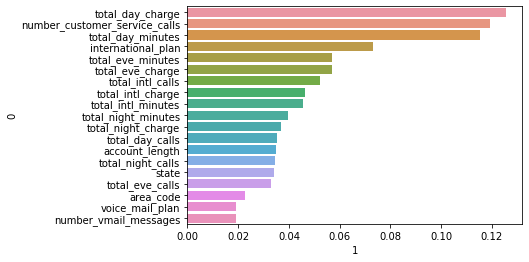

In [58]:
sns.barplot(data=df_imp,x=1,y=0);

## De acordo com esse algoritmo, as melhores 10 variáveis são:

In [59]:
df_imp.iloc[0:10,0]

8                  total_day_charge
18    number_customer_service_calls
6                 total_day_minutes
2                international_plan
9                 total_eve_minutes
11                 total_eve_charge
16                 total_intl_calls
17                total_intl_charge
15               total_intl_minutes
12              total_night_minutes
Name: 0, dtype: object

In [60]:
melhores = list(df_imp.iloc[0:10,0])

## Criando um novo dataframe com essas variáveis para fazer o treinamento

In [61]:
df_melhores_extra = df[melhores]

In [62]:
cat_extra = [x for x in df_melhores_extra.columns if df[x].dtype=='object']

In [63]:
num_extra = [x for x in df_melhores_extra.columns if x not in cat_extra]

In [64]:
min_max_extra = MinMaxScaler()

In [65]:
num_extra_s = min_max_extra.fit_transform(df[num_extra].values)

In [66]:
onehot_extra = OneHotEncoder(sparse=False)

In [67]:
cat_extra_cod = onehot_extra.fit_transform(df[cat_extra].values)

In [68]:
todas_var_extra = np.concatenate([num_extra_s,cat_extra_cod],axis=1)

In [69]:
resultado_extra = cross_val_score(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),X=todas_var_extra,\
                                  y=y_encod,cv=kf,scoring='balanced_accuracy')

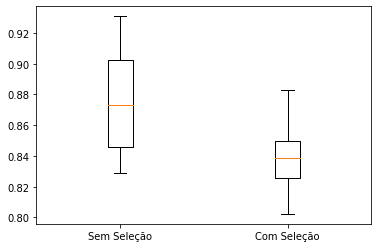

In [70]:
plt.boxplot([x for x in [resultados[len(resultados)-1],resultado_extra]],labels=['Sem Seleção','Com Seleção']);

In [71]:
x_treino_extra, x_teste_extra, y_treino_extra, y_teste_extra = train_test_split(todas_var_extra,y_encod,test_size=0.3,random_state=1)

In [72]:
xgb_extra = XGBClassifier(use_label_encoder=False)
xgb_extra.fit(x_treino_extra,y_treino_extra)

[18:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [73]:
print(classification_report(y_teste_extra,xgb_extra.predict(x_teste_extra)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       855
           1       0.85      0.66      0.74       145

    accuracy                           0.93      1000
   macro avg       0.90      0.82      0.85      1000
weighted avg       0.93      0.93      0.93      1000



In [74]:
confusao = confusion_matrix(y_teste_extra,xgb_extra.predict(x_teste_extra),labels=[0,1])
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 0: 98.0117%
Acurácia classe 1: 65.5172%


## O modelo piorou

## 2) SelectKBest

In [75]:
score_funcs = [('f_classif',f_classif),('mutual_info_classif',mutual_info_classif), ('chi2',chi2)]

In [76]:
resultados_kbest = []
for nome,func in score_funcs:
    kbest = SelectKBest(score_func=func,k=10)
    kbest.fit(df_extra.values,y)
    
    cat_kbest = [x for x in df_extra.iloc[:,kbest.get_support()].columns if df[x].dtype=='object']
    num_kbest = [x for x in df_extra.iloc[:,kbest.get_support()].columns if x not in [x for x in df_extra.iloc[:,kbest.get_support()].columns if df[x].dtype=='object']]
    
    minmax_kbest = MinMaxScaler()
    var_num_kbest_s = minmax_kbest.fit_transform(df[num_kbest].values)
    
    onehot_kbest = OneHotEncoder(sparse=False)
    var_cat_kbest = onehot_kbest.fit_transform(df[cat_kbest].values)
    
    todas_var_kbest = np.concatenate([var_num_kbest_s,var_cat_kbest],axis=1)
    
    resultados_kbest.append(cross_val_score(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),X=todas_var_kbest,\
                                  y=y_encod,cv=kf,scoring='balanced_accuracy'))

In [77]:
nomes_kbest = [x[0] for x in score_funcs]

In [78]:
kbest_comparacao = [list(x) for x in resultados_kbest]

In [79]:
kbest_comparacao.append(list(resultados[len(resultados)-1]))

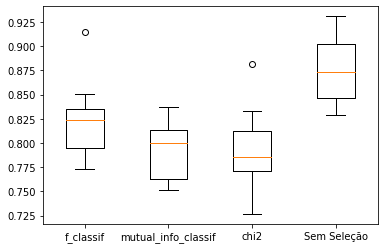

In [80]:
plt.boxplot([x for x in kbest_comparacao],labels=nomes_kbest+['Sem Seleção']);

## Apesar de parecer que o mutual_info_classif foi melhor, ele não foi, analisei caso a caso dividindo em treino e teste e o melhor foi o f_classif

In [81]:
kbest = SelectKBest(score_func=f_classif,k=10)
kbest.fit(df_extra.values,y)
    
cat_kbest = [x for x in df_extra.iloc[:,kbest.get_support()].columns if df[x].dtype=='object']
num_kbest = [x for x in df_extra.iloc[:,kbest.get_support()].columns if x not in [x for x in df_extra.iloc[:,kbest.get_support()].columns if df[x].dtype=='object']]
    
minmax_kbest = MinMaxScaler()
var_num_kbest_s = minmax_kbest.fit_transform(df[num_kbest].values)
    
onehot_kbest = OneHotEncoder(sparse=False)
var_cat_kbest = onehot_kbest.fit_transform(df[cat_kbest].values)
    
todas_var_kbest = np.concatenate([var_num_kbest_s,var_cat_kbest],axis=1)

In [82]:
x_treino_kbest, x_teste_kbest, y_treino_kbest, y_teste_kbest = train_test_split(todas_var_kbest,y_encod,test_size=0.3,random_state=1)

In [83]:
xgb_kbest = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
xgb_kbest.fit(x_treino_kbest,y_treino_kbest)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [84]:
print(classification_report(y_teste_kbest,xgb_kbest.predict(x_teste_kbest)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       855
           1       0.78      0.65      0.71       145

    accuracy                           0.92      1000
   macro avg       0.86      0.81      0.83      1000
weighted avg       0.92      0.92      0.92      1000



In [85]:
confusao = confusion_matrix(y_teste_kbest,xgb_kbest.predict(x_teste_kbest),labels=[0,1])
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 0: 96.8421%
Acurácia classe 1: 64.8276%


## O resultado foi pior que com o ExtraTrees

## 3) RFE (Recursive Feature Elimination)

In [86]:
rfe = RFE(XGBClassifier(use_label_encoder=False,eval_metric='logloss'),n_features_to_select=10)

In [87]:
rfe.fit(df_extra.values,y_encod)

RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, enable_categorical=False,
                            eval_metric='logloss', gamma=None, gpu_id=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_delta_step=None,
                            max_depth=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=None,
                            tree_method=None, use_label_encoder=False,
                            validate_parameters=None, verbosity=None),
    n_features_to_select=10)

In [88]:
rfe.support_

array([ True, False,  True,  True, False,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True, False,
        True])

In [89]:
cat_rfe = [x for x in df_extra.iloc[:,rfe.get_support()].columns if df[x].dtype=='object']
num_rfe = [x for x in df_extra.iloc[:,rfe.get_support()].columns if x not in cat_rfe]

In [90]:
minmax_rfe = MinMaxScaler()
var_num_rfe_s = minmax_rfe.fit_transform(df[num_rfe].values)
    
onehot_rfe = OneHotEncoder(sparse=False)
var_cat_rfe = onehot_rfe.fit_transform(df[cat_rfe].values)
    
todas_var_rfe = np.concatenate([var_num_rfe_s,var_cat_rfe],axis=1)

In [91]:
resultado_rfe = cross_val_score(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),X=todas_var_rfe,\
                                  y=y_encod,cv=kf,scoring='balanced_accuracy')

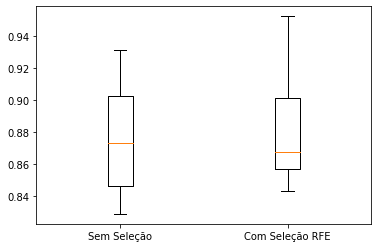

In [92]:
plt.boxplot([x for x in [resultados[len(resultados)-1],resultado_rfe]],labels=['Sem Seleção','Com Seleção RFE']);

In [93]:
x_treino_rfe, x_teste_rfe, y_treino_rfe, y_teste_rfe = train_test_split(todas_var_rfe,y_encod,test_size=0.3,random_state=1)

In [94]:
xgb_rfe = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
xgb_rfe.fit(x_treino_rfe,y_treino_rfe)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [95]:
print(classification_report(y_teste_rfe,xgb_rfe.predict(x_teste_rfe)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       855
           1       0.89      0.77      0.82       145

    accuracy                           0.95      1000
   macro avg       0.92      0.87      0.90      1000
weighted avg       0.95      0.95      0.95      1000



In [96]:
confusao = confusion_matrix(y_teste_rfe,xgb_rfe.predict(x_teste_rfe),labels=[0,1])
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 0: 98.3626%
Acurácia classe 1: 76.5517%


## O RFE é bem superior aos demais métodos

## As melhores 10 variáveis para este problema são:

In [97]:
cat_rfe+num_rfe

['state',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_eve_minutes',
 'total_night_minutes',
 'total_intl_minutes',
 'total_intl_calls',
 'number_customer_service_calls']

## Otimizando os hiperparâmetros

In [98]:
parametros = {'max_depth':list(range(3,10)),'n_estimators':[100,250],'learning_rate':[0.1,0.2,0.3],\
             'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],'subsample':[0.6,0.7,0.8]}

In [99]:
todas_var_rfe_over, y_encod_over = smote.fit_resample(todas_var_rfe,y_encod)

In [100]:
rand_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False,eval_metric='logloss'),cv=kf,\
                                 scoring='balanced_accuracy',n_jobs=-1,param_distributions=parametros,verbose=2,\
                                n_iter=1000)

rand_search.fit(todas_var_rfe_over,y_encod_over)

Fitting 10 folds for each of 630 candidates, totalling 6300 fits


C:\Users\bruno\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 630 is smaller than n_iter=1000. Running 630 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=Non...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
              

In [101]:
rand_search.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'max_depth': 9,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8}

## Preparando os dados de teste

In [ ]:
df_teste = pd.read_csv('projeto4_telecom_teste.csv')

In [104]:
y_teste = df_teste['churn']

In [105]:
y_encod_teste = []
for x in y_teste:
    if x=='yes':
        y_encod_teste.append(1)
    else:
        y_encod_teste.append(0)

In [106]:
df_teste = df_teste[cat_rfe+num_rfe]

In [107]:
cat_teste = [x for x in df_teste.columns if df_teste[x].dtype=='object']

In [108]:
num_teste = [x for x in df_teste.columns if x not in cat_teste]

In [109]:
cat_teste_cod = onehot_rfe.transform(df_teste[cat_teste].values)

In [110]:
num_teste_s = minmax_rfe.transform(df_teste[num_teste].values)

In [111]:
todas_var_teste = np.concatenate([num_teste_s,cat_teste_cod],axis=1)

In [112]:
print(classification_report(y_encod_teste,rand_search.predict(todas_var_teste)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1443
           1       0.92      0.80      0.85       224

    accuracy                           0.96      1667
   macro avg       0.94      0.89      0.92      1667
weighted avg       0.96      0.96      0.96      1667



In [113]:
confusao = confusion_matrix(y_encod_teste,rand_search.predict(todas_var_teste),labels=[0,1])

In [114]:
print(f'Acurácia classe 0: {confusao[0,0]/(confusao[0,1]+confusao[0,0])*100:.4f}%')

Acurácia classe 0: 98.8912%


In [115]:
print(f'Acurácia classe 1: {confusao[1,1]/(confusao[1,0]+confusao[1,1])*100:.4f}%')

Acurácia classe 1: 79.9107%
